In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import gaussian_process
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import os
import pickle
from scipy import interpolate
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from tensorflow.keras import backend as K

def precision_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    predicted_positives = K.sum( K.round(K.clip(y_pred,0,1)) )
    return true_positives / ( predicted_positives + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    real_positives = K.sum( K.round(K.clip(y_true,0,1)) )
    return true_positives / (real_positives + K.epsilon())

def f_score(y_true, y_pred):
    P = precision_m(y_true, y_pred)
    R = recall_m(y_true, y_pred)
    return (2*P*R) / (P+R+K.epsilon())

#Evaluation for binary classification
def evaluate(y_pred, label): 

    index_n = np.where(label == 0)[0]
    index_p = np.where(label == 1)[0]

    true_positif = (y_pred[index_p] == 1).sum()
    false_positif = (y_pred[index_n] == 1).sum()

    true_negatif = (y_pred[index_n] == 0).sum()
    false_negatif = (y_pred[index_p] == 0).sum()

    m = np.array([
        [true_negatif, false_positif],
        [false_negatif, true_positif]
    ])
    
    precision = true_positif/(true_positif + false_positif + K.epsilon())
    recall = true_positif/(true_positif + false_negatif + K.epsilon())
    f_score = (2*precision*recall)/(precision+recall + K.epsilon())
    
    return precision, recall,f_score, m


In [34]:
def lorentzian_components(params_gr, t):

    '''
    Simulated effects of pulsations and granulations
    
    source: Dumusque et al 2011
    https://www.aanda.org/articles/aa/pdf/2011/01/aa14097-10.pdf
    
    Inputs
        - params_gr := A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste
        - t = time in seconds

    ''' 
    
    # define frequency arrays  
    # The frequency ν goes from 1/T to the Nyquist frequency in steps of 1/T
    N    = len(t)
    Ttot = (max(t)-min(t)) # total time in seconds
    dt = np.median(np.diff(t)) # sampling rate
    freq_Nyq = (1.0/dt)/2 # Nyquist frequency
    freq  = np.arange(1.0/Ttot,freq_Nyq,1.0/Ttot, dtype='float64')
    # freq  = np.linspace(1.0/Ttot, 1./2/dt, len(t)) # Hz

    # define the power spectra as a sum of 3 components for granulation, mesogranulation and supergranulation + oscillations
    A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste = params_gr 
    
    VPSD = A1 / (1+(B1*freq)**C1) + A2 / (1+(B2*freq)**C2) +  A3 / (1+(B3*freq)**C3) + \
                AL * (Gm**2/((freq-nu0)**2+Gm**2)) +  cste  
    
    #VPSD /= 1e6     # units of VPSD is (m/s)**2/Hz
    VPSD *= (freq[-1] - freq[0])
           
    # take random phase between 0 and 2pi
    phase = 2*np.pi*np.random.rand(1,len(VPSD))
    #print(len(phase), len(VPSD))
    
    # Synthetic radial velocity measurements
    ysyn = np.zeros(N)
    for i in range(N):
        ysyn[i] = np.sum(np.sqrt(VPSD)*np.sin(2*np.pi*t[i]*freq+phase))
       
    return ysyn




def generate_data_H0(params_gr, params_act, t):
    
    '''
    Inputs:
    - params_gr:= 
            see function lorentzian_components(params_gr, t)
    - params_act:=
            - amplitude (GP amplitude)
            - gam = 2/epsilon in the paper (GP gamma)
            - logP = log(P) in the paper (GP period)
            - met = 1.0 in the paper (GP metric)
    
    - N = number of data points
        
    Outputs:
        - t = time (days)
        - y = RV (m/s)
        - yerr =  intrinsic errors (m/s)
    '''
    
    # =========================================================================
    # Generate a Lorentzian component that represents the pulsations and
    # three components for the granulation, mesogranulation and su-
    # pergranulation
    ts    = t*24*3600 # seconds
    ygr = lorentzian_components(params_gr, ts)
    
    # =========================================================================
    # Generate activity component based on GP
    
    # define the QP kernel for the GP (see https://george.readthedocs.io/en/latest/user/kernels/)
    tau, epsilon, Prot, amp = params_act
    k = gaussian_process.kernels.RBF(tau)
    k*= gaussian_process.kernels.ExpSineSquared(np.sqrt(epsilon),Prot)
    k*= amp**2
    
    gp = gaussian_process.GaussianProcessRegressor(k)
    t_gp = np.reshape(t, (t.shape[0],1))

    yact = gp.sample_y(t_gp, n_samples = 100)[:,np.random.randint(0,100)]
    
    
    # =========================================================================
    # Generate the intrincsic errors
    eb = np.random.normal(loc=3,scale=0.30, size=len(t)) # m/s
    if (any(eb < 0)) : eb = np.where(eb<0, 1.5, eb)
    yerr = np.random.normal(loc=0, scale=eb, size=len(t)) # this has to be defined according to the paper
    #print('std(yerr) = %f m/s'%np.std(yerr))

    # =========================================================================
    # Generate the final synthetic time series
    # activity + granulation + the intrinsic errors 
    ytot = ygr + yact + yerr * np.random.randn(len(t))
    
    return ytot, eb




def generate_planete(params_pl,t):
    """
    - params_pl
            - Ppl (Orbital period)
            - K (semi-amplitude)
            - T0 ( Phase à l'origine)
    """
    Ppl, K, T0 = params_pl
    return K*np.sin(2*np.pi*(t-T0)/Ppl)



def generate_data(t,dt,Ttot,freq,params_gp, params_gr,params_pl, nbr_pl_to_inject):
    
    # Generate H0 data, activity signal 
    y_noise, eb = generate_data_H0(params_gr, params_gp, t)
    
    #Without planet 
    if ( nbr_pl_to_inject == 0):
        GLS = LombScargle(t, y_noise,eb).power(freq,method='cython')
        label = 0
        max_value = np.array([freq[np.argmax(GLS)],np.max(GLS)])
        Ppl = 0
        
    #With planet
    else :
        # Add the planet signal to noise and other planetary signal
        y_pl = generate_planete(params_pl, t)
        y_i = y_noise + y_pl 
        
        # Create GLS
        GLS = LombScargle(t, y_i,eb).power(freq,method='cython')
        max_value = np.array([freq[np.argmax(GLS)],np.max(GLS)])
        if ( np.isclose(1/params_pl[0], max_value[0], atol=0.002) ): 
            # case where best_freq (max of GLS) is corresponding to any frequency planet
            label = 1
        else:
            label = 0
            
        
    return GLS, max_value, label



def generate_time(Ttot):
    #Generate time and frequency
    #Over-sampling
    facteur_surech = 10
    N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
    t_over = np.linspace(0,Ttot,N) #days
    
    # Irregular sampling 1 : with normal distribution
    facteur_ech = 20
    t = np.zeros(Ttot)

    ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
    t[0] = t_over[ ind0 ]
    ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
    t[-1] = t_over[ ind_fin ]

    pas = N/Ttot
    for i in range(Ttot-2):
        ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
        t[i+1] =  t_over[ind]

    dt = np.median(np.diff(t))
    fmin = 1/(t[-1]-t[0])
    fmax = (1/dt)/2 
    freq = np.linspace(fmin,fmax,990)
    
    return freq, t,dt

In [4]:
Ttot = 200
freq, t, dt= generate_time(Ttot)

A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz
params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]

In [35]:
N = 5000
GLS_H0 = np.zeros((N,freq.shape[0]))

for i in range(N):
    #Params_GP
    Prot = 15 + np.random.normal(loc =0, scale =1) #random.randint(5,90)
    amp  = 2 + np.random.normal(loc =0, scale =0.1)#gamma.rvs(2.0, 0.5) 
    epsilon = 0.5 + np.random.normal(loc =0, scale =0.01) #uniform.rvs(0.5, 1)
    tau = 2*Prot + np.random.normal(loc =0, scale =1)#np.random.normal(3*Prot, 0.1*Prot)
    params_gp = [tau, epsilon, Prot, amp]

    GLS, Maxs,label = generate_data(t,dt,Ttot,freq,params_gp,params_gr, [0,0,0],0)
    GLS_H0[i,:] = GLS

In [36]:
GLS_mean_H0 = np.mean(GLS_H0, axis = 0) 

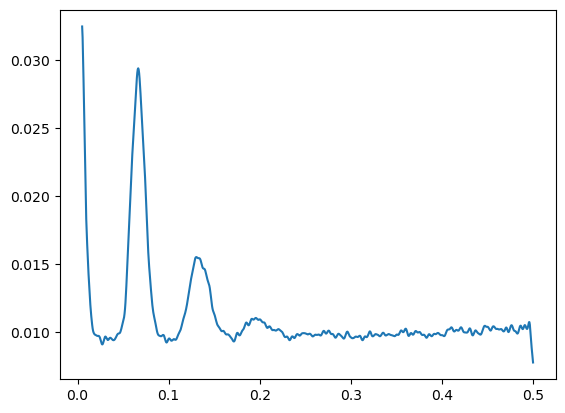

In [37]:
plt.plot(freq,GLS_mean_H0)

## Test with fixed frequency planet

In [231]:
N_test = 3000
GLS_test1, Label_test1, Maxs_test1 = np.zeros((N_test,freq.shape[0])), np.zeros(N_test), np.zeros((N_test,2))
GLS_test2, Label_test2, Maxs_test2 = np.zeros((N_test,freq.shape[0])), np.zeros(N_test), np.zeros((N_test,2))

In [232]:
#Params_first planet signal 
Ppl1= 5#random.uniform(10*dt,Ttot/2) 
A1 = 1#loguniform.rvs(0.1, 10)
T01 = random.uniform(0,Ppl1) #random.uniform(0,Ppl)
params_pl1 = [Ppl1,A1,T01]

#Params second planet signal
Ppl2= 20#random.uniform(10*dt,Ttot/2) 
A2 = 1#loguniform.rvs(0.1, 10)
T02 = random.uniform(0,Ppl2) #random.uniform(0,Ppl)
params_pl2 = [Ppl2,A2,T02]

for i in range(round(N_test/2)):
    GLS, Maxs, label = generate_data(t,dt,Ttot,freq,params_gp,params_gr, params_pl1,1)
    GLS_test1[i,:] = GLS
    Maxs_test1[i,:] = Maxs
    Label_test1[i] = label
    
    GLS, Maxs,label = generate_data(t,dt,Ttot,freq,params_gp,params_gr, params_pl2,1)
    GLS_test2[i,:] = GLS
    Maxs_test2[i,:] = Maxs
    Label_test2[i] = label
    
for k in range(round(N_test/2),N_test):
    GLS, Maxs, label = generate_data(t,dt,Ttot,freq,params_gp,params_gr, params_pl1,0)
    GLS_test1[k,:], GLS_test2[k,:] = GLS, GLS
    Maxs_test1[k,:],Maxs_test2[k,:] = Maxs, Maxs
    Label_test1[k], Label_test2[k] = label, label

In [233]:
#First test, take the maximum and compared to a threshold
Maxs11 = Maxs_test1[:,1]
Maxs12 = Maxs_test2[:,1]
#Second test, divide GLS_test by mean_GLS under H0, and take the max
Maxs21 = np.max(GLS_test1 / GLS_mean_H0, axis = 1)
Maxs22 = np.max(GLS_test2 / GLS_mean_H0, axis = 1)

Text(0, 0.5, 'Pdet')

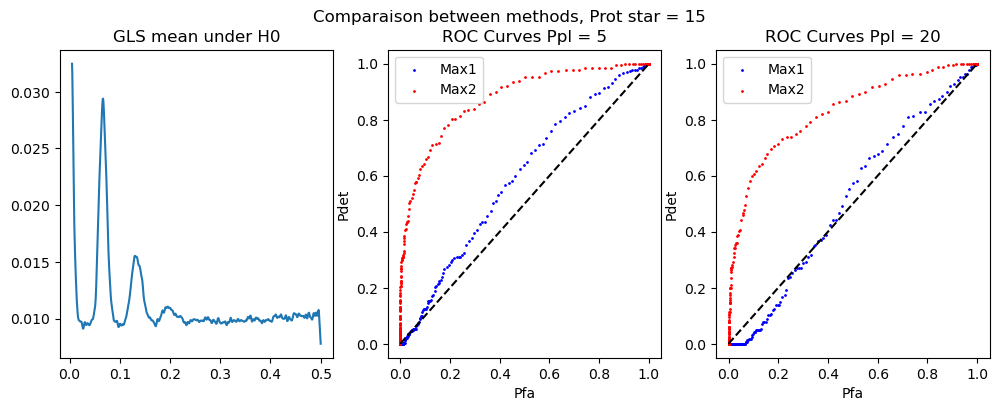

In [234]:
#Comparaison between cnn and max test normalized by h0 distribution on fixed GP parameters data 
N = 200
threshold_max11 = np.linspace(np.min(Maxs11),np.max(Maxs11),N)
threshold_max12 = np.linspace(np.min(Maxs12),np.max(Maxs12),N)

threshold_max21 = np.linspace(np.min(Maxs21),np.max(Maxs21),N)
threshold_max22 = np.linspace(np.min(Maxs22),np.max(Maxs21),N)

Pdet11, Pfa11 = np.zeros(N), np.zeros(N)
Pdet12, Pfa12 = np.zeros(N), np.zeros(N)
Pdet21, Pfa21 = np.zeros(N), np.zeros(N)
Pdet22, Pfa22 = np.zeros(N), np.zeros(N)

for i in range(N):
    y_seuil = np.where(Maxs11 > threshold_max11[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test1)
    Pdet11[i], Pfa11[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
        
    y_seuil = np.where(Maxs12 > threshold_max12[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test2)
    Pdet12[i], Pfa12[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    
    y_seuil = np.where(Maxs21 > threshold_max21[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test1)
    Pdet21[i], Pfa21[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
        
    y_seuil = np.where(Maxs22 > threshold_max22[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test2)
    Pdet22[i], Pfa22[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])

    
plt.figure(figsize=(12,4))
plt.suptitle("Comparaison between methods, Prot star = 15\n")

plt.subplot(131)
plt.title("GLS mean under H0")
plt.plot(freq,GLS_mean_H0)

plt.subplot(132)
plt.title("ROC Curves Ppl = 5")
plt.scatter(Pfa11, Pdet11, label='Max1', s=1, c='b'),plt.legend()
plt.scatter(Pfa21, Pdet21, label='Max2', s=1, c='r'),plt.legend()
plt.plot(np.linspace(0,1,N),np.linspace(0,1,N), '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")

plt.subplot(133)
plt.title("ROC Curves Ppl = 20")
plt.scatter(Pfa12, Pdet12, label='Max1', s=1, c='b'),plt.legend()
plt.scatter(Pfa22, Pdet22, label='Max2', s=1, c='r'),plt.legend()
plt.plot( np.linspace(0,1,N), np.linspace(0,1,N), '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")

## CNNs

In [128]:
#Data train 1
N_train = 10000

#Params_first planet signal
X_GLS1 = []
X_maxs1 = []
Label1 = []
Ppl1= 5#random.uniform(10*dt,Ttot/2) 
A1 = 1#loguniform.rvs(0.1, 10)
T01 = random.uniform(0,Ppl1) #random.uniform(0,Ppl)
params_pl1 = [Ppl1,A1,T01]

count_neg = 0
count_pos = 0

# First dataset 
while (count_pos < round(N_train/2)):
    #H1 data
    GLS, Maxs, Label = generate_data(t,dt,Ttot,freq,params_gp,params_gr, params_pl1,1)
    if ( Label == 1):
        X_GLS1.append(GLS)
        X_maxs1.append(Maxs)
        Label1.append(Label)
        count_pos +=1
    if ( Label == 0 and count_neg < round(N_train/4)):
        X_GLS1.append(GLS)
        X_maxs1.append(Maxs)
        Label1.append(Label)
        count_neg +=1
        
print("count positive = ", count_pos)
print("count negative = ", count_neg)

while(count_neg < round(N_train/2)):
    GLS, Maxs, Label = generate_data(t,dt,Ttot,freq,params_gp,params_gr, [0,0,0],0)
    X_GLS1.append(GLS)
    X_maxs1.append(Maxs)
    Label1.append(Label)
    count_neg +=1

print("count positive = ", count_pos)
print("count negative = ", count_neg)

count positive =  5000
count negative =  2500
count positive =  5000
count negative =  5000


In [130]:
#Data pre-processing 
#shuffle
c = list(zip(X_GLS1, X_maxs1,Label1))
random.shuffle(c)
X_GLS1, X_maxs1, Label1 = zip(*c)

#Periodogramme
X_shape1 =  [N_train,len(X_GLS1[0]), 1]
X1_tensor1 = tf.convert_to_tensor(X_GLS1, dtype = 'float32')
X11 = tf.reshape(X1_tensor1, X_shape1 )

#Max values
X2_tensor1 = tf.convert_to_tensor(X_maxs1, dtype = 'float32')
X21 = tf.reshape(X2_tensor1, (N_train, 2,1))

#Label
Y_tensor1 = tf.convert_to_tensor(Label1,dtype='float32')
Y1 = tf.reshape(Y_tensor1, (N_train,1 ))

#Split train/validation
pourcentage = 0.8
split = round(pourcentage * N_train)
X_train_GLS1, X_val_GLS1 = X11[0:split, :, :], X11[split:, :, :]
X_train_maxs1,X_val_maxs1 = X21[0:split, :, :], X21[split:, :, :]
Y_train1, Y_val1 = Y1[0:split], Y1[split:,:]

print("Periodogramme train size : ", X_train_GLS1.shape)
print("Periodogramme validation size : ", X_val_GLS1.shape,"\n")
print("Max_values train size : ", X_train_maxs1.shape)
print("Max_values validation size : ", X_val_maxs1.shape,"\n")
print("Label train size : ", Y_train1.shape)
print("Label validation size : ", Y_val1.shape)

Periodogramme train size :  (8000, 990, 1)
Periodogramme validation size :  (2000, 990, 1) 

Max_values train size :  (8000, 2, 1)
Max_values validation size :  (2000, 2, 1) 

Label train size :  (8000, 1)
Label validation size :  (2000, 1)


In [243]:
#Model with functional API Keras

#periodogramme as input to a CNN
inputs1 = tf.keras.Input(shape=(990,1))
x1 = layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, padding = 'same',
                   activation='relu', use_bias = True,input_shape= (990,1))(inputs1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,6,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,8,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
outputs1 = layers.Flatten()(x1)

#max_values as input to a dense layers 
inputs2 = tf.keras.Input(shape=(2,1))
x2 = layers.Dense(2, activation = 'relu')(inputs2)
outputs2 =  layers.Flatten()(x2)

#output of the two network concatenate for input as a dense final network
x = layers.concatenate([outputs1, outputs2])

x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

In [244]:
model1 = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="ExoplANNET1")

In [245]:
#First cnn
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f_score', patience = 3, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

model1.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4),
              metrics =[tf.keras.metrics.BinaryAccuracy(),precision_m, recall_m, f_score])

y_before_train = model1.evaluate( x = [X_train_GLS1, X_train_maxs1], y = Y_train1, batch_size = 128)

63/63 [==============================] - 3s 46ms/step - loss: 0.6931 - binary_accuracy: 0.4308 - precision_m: 0.0517 - recall_m: 0.0079 - f_score: 0.0135


In [246]:
#Train first cnn
start = time.time()
history = model1.fit(x = [X_train_GLS1, X_train_maxs1], y = Y_train1, batch_size = 128, epochs = 50, verbose = 1,
                    callbacks=[early_stopping], validation_data = ([X_val_GLS1,X_val_maxs1], Y_val1))                                                      
time_train = time.time() - start

Epoch 1/50
63/63 [==============================] - 10s 138ms/step - loss: 0.6799 - binary_accuracy: 0.6556 - precision_m: 0.8496 - recall_m: 0.3863 - f_score: 0.5129 - val_loss: 0.6474 - val_binary_accuracy: 0.7130 - val_precision_m: 0.9679 - val_recall_m: 0.4410 - val_f_score: 0.6027
Epoch 2/50
63/63 [==============================] - 9s 145ms/step - loss: 0.5127 - binary_accuracy: 0.8216 - precision_m: 0.8949 - recall_m: 0.7416 - f_score: 0.7877 - val_loss: 0.3242 - val_binary_accuracy: 0.8645 - val_precision_m: 0.9541 - val_recall_m: 0.7654 - val_f_score: 0.8486
Epoch 3/50
63/63 [==============================] - 9s 145ms/step - loss: 0.2390 - binary_accuracy: 0.9144 - precision_m: 0.9055 - recall_m: 0.9264 - f_score: 0.9145 - val_loss: 0.1710 - val_binary_accuracy: 0.9440 - val_precision_m: 0.9223 - val_recall_m: 0.9738 - val_f_score: 0.9469
Epoch 4/50
63/63 [==============================] - 9s 139ms/step - loss: 0.1737 - binary_accuracy: 0.9360 - precision_m: 0.9223 - recall_m: 

63/63 [==============================] - 9s 139ms/step - loss: 0.0671 - binary_accuracy: 0.9769 - precision_m: 0.9667 - recall_m: 0.9883 - f_score: 0.9772 - val_loss: 0.0709 - val_binary_accuracy: 0.9730 - val_precision_m: 0.9616 - val_recall_m: 0.9874 - val_f_score: 0.9740


Temps d'entrainement :  264.6925208568573 s


Text(0.5, 0, 'Epochs')

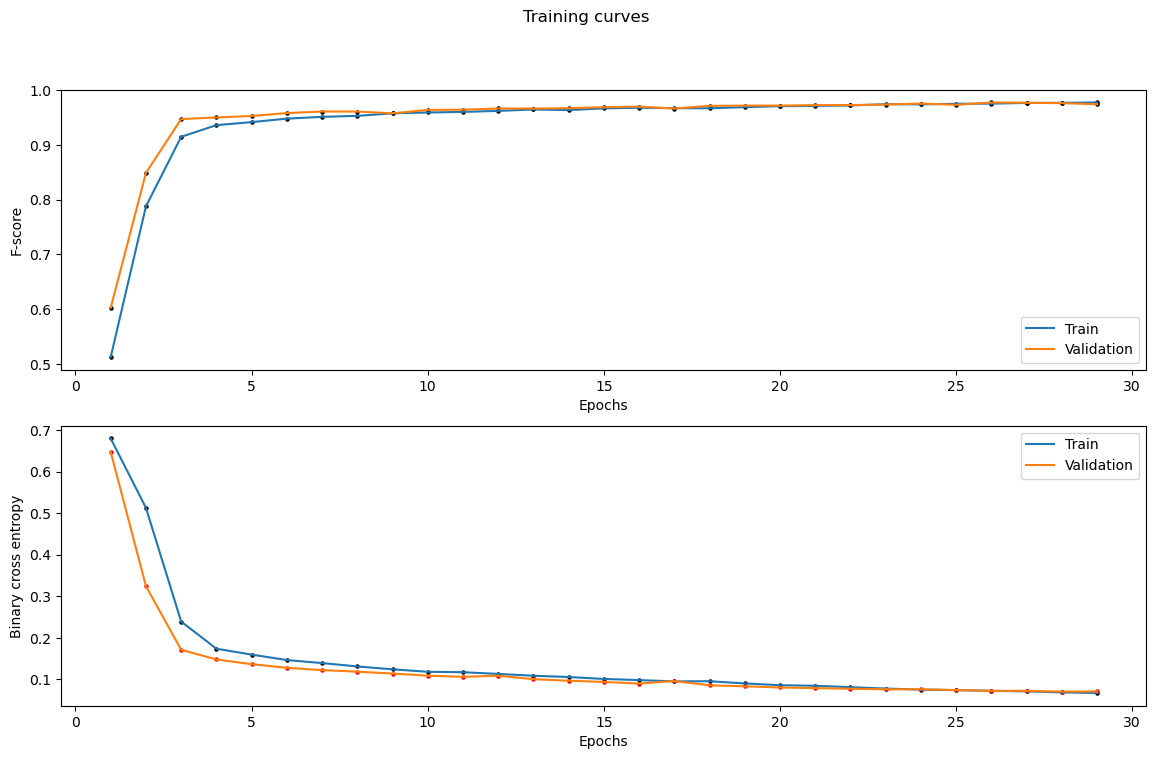

In [247]:
print("Temps d'entrainement : ", time_train, "s")

x = np.arange(1,len(history.history['loss'])+1,1)

plt.figure(figsize=(14,8))
plt.suptitle("Training curves")
plt.subplot(211)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(x,history.history['f_score'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_f_score'], s=5, c='k')
plt.plot(x,history.history['val_f_score'], label='Validation'), plt.legend()
plt.ylabel("F-score")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['loss'], s=5, c='k')
plt.plot(x,history.history['loss'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_loss'], s=5, c='r')
plt.plot(x,history.history['val_loss'], label='Validation'), plt.legend()
plt.ylabel("Binary cross entropy")
plt.xlabel("Epochs")

In [248]:
#Data test first set
#shuffle
c = list(zip(GLS_test1, Maxs_test1,Label_test1))
random.shuffle(c)
X_GLS_test1, X_Maxs_test1,Y_test1 = zip(*c)

#Periodogramme
X1_test_tensor1 = tf.convert_to_tensor(X_GLS_test1, dtype= 'float32')
X1_test_shape1 =  [len(X_GLS_test1),len(X_GLS_test1[0]), 1]
X_GLS_test1 = tf.reshape(X1_test_tensor1, X1_test_shape1 )

#Max values
X2_test_tensor1 = tf.convert_to_tensor(X_Maxs_test1, dtype= 'float32')
X_maxs_test1 = tf.reshape(X2_test_tensor1, (len(X_Maxs_test1), len(X_Maxs_test1[0]),1))

#Label
Y_test_tensor1 = tf.convert_to_tensor(Y_test1)
Y_test1 = tf.reshape(Y_test_tensor1, (len(Y_test1),1 ))

print("X1_test shape : ", X_GLS_test1.shape)
print("X2_test shape : ", X_maxs_test1.shape)
print("label_test shape : ", Y_test1.shape)

X1_test shape :  (3000, 990, 1)
X2_test shape :  (3000, 2, 1)
label_test shape :  (3000, 1)


In [249]:
y_pred_cnn1 = model1.predict( x =[X_GLS_test1, X_maxs_test1])

94/94 [==============================] - 4s 41ms/step


In [205]:
#Data train 2
N_train = 10000

#Params_second planet signal
X_GLS2 = []
X_maxs2 = []
Label2 = []

Ppl2= 20#random.uniform(10*dt,Ttot/2) 
A2 = 1#loguniform.rvs(0.1, 10)
T02 = random.uniform(0,Ppl2) #random.uniform(0,Ppl)
params_pl2 = [Ppl2,A2,T02]

count_neg = 0
count_pos = 0

# Second dataset 
while (count_pos < round(N_train/2)):
    #H1 data
    GLS, Maxs, Label = generate_data(t,dt,Ttot,freq,params_gp,params_gr, params_pl2,1)
    if ( Label == 1):
        X_GLS2.append(GLS)
        X_maxs2.append(Maxs)
        Label2.append(Label)
        count_pos +=1
    if ( Label == 0 and count_neg < round(N_train/4)):
        X_GLS2.append(GLS)
        X_maxs2.append(Maxs)
        Label2.append(Label)
        count_neg +=1
        
print("count positive = ", count_pos)
print("count negative = ", count_neg)

while(count_neg < round(N_train/2)):
    GLS, Maxs, Label = generate_data(t,dt,Ttot,freq,params_gp,params_gr, [0,0,0],0)
    X_GLS2.append(GLS)
    X_maxs2.append(Maxs)
    Label2.append(Label)
    count_neg +=1

print("count positive = ", count_pos)
print("count negative = ", count_neg)

count positive =  5000
count negative =  2500
count positive =  5000
count negative =  5000


In [213]:
#Data pre-processing 
#shuffle
c = list(zip(X_GLS2, X_maxs2,Label2))
random.shuffle(c)
GLS2, maxs2, Y2 = zip(*c)

#Periodogramme
X_shape2 =  [N_train,len(X_GLS2[0]), 1]
X1_tensor2 = tf.convert_to_tensor(GLS2, dtype = 'float32')
X12 = tf.reshape(X1_tensor2, X_shape2 )

#Max values
X2_tensor2 = tf.convert_to_tensor(maxs2, dtype = 'float32')
X22 = tf.reshape(X2_tensor2, (N_train, 2,1))

#Label
Y_tensor2 = tf.convert_to_tensor(Y2,dtype='float32')
Y2 = tf.reshape(Y_tensor2, (N_train,1 ))

#Split train/validation
pourcentage = 0.8
split = round(pourcentage * N_train)
X_train_GLS2, X_val_GLS2 = X12[0:split, :, :], X12[split:, :, :]
X_train_maxs2,X_val_maxs2 = X22[0:split, :, :], X22[split:, :, :]
Y_train2, Y_val2 = Y2[0:split], Y2[split:,:]

print("Periodogramme train size : ", X_train_GLS2.shape)
print("Periodogramme validation size : ", X_val_GLS2.shape,"\n")
print("Max_values train size : ", X_train_maxs2.shape)
print("Max_values validation size : ", X_val_maxs2.shape,"\n")
print("Label train size : ", Y_train2.shape)
print("Label validation size : ", Y_val2.shape)

Periodogramme train size :  (8000, 990, 1)
Periodogramme validation size :  (2000, 990, 1) 

Max_values train size :  (8000, 2, 1)
Max_values validation size :  (2000, 2, 1) 

Label train size :  (8000, 1)
Label validation size :  (2000, 1)


In [222]:
model2 = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="ExoplANNET2")

In [223]:
#second cnn
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f_score', patience = 3, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

model2.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4),
              metrics =[tf.keras.metrics.BinaryAccuracy(),precision_m, recall_m, f_score])

y_before_train = model2.evaluate( x = [X_train_GLS2, X_train_maxs2], y = Y_train2, batch_size = 128)

63/63 [==============================] - 4s 51ms/step - loss: 0.6933 - binary_accuracy: 0.4871 - precision_m: 0.4947 - recall_m: 0.9700 - f_score: 0.6539


In [224]:
#Train second cnn
start = time.time()
history = model2.fit(x = [X_train_GLS2, X_train_maxs2], y = Y_train2, batch_size = 128, epochs = 50, verbose = 1,
                    callbacks=[early_stopping], validation_data = ([X_val_GLS2,X_val_maxs2], Y_val2))                                                      
time_train = time.time() - start

Epoch 1/50
63/63 [==============================] - 11s 147ms/step - loss: 0.6837 - binary_accuracy: 0.6909 - precision_m: 0.7508 - recall_m: 0.7262 - f_score: 0.6566 - val_loss: 0.6537 - val_binary_accuracy: 0.9335 - val_precision_m: 0.9275 - val_recall_m: 0.9412 - val_f_score: 0.9336
Epoch 2/50
63/63 [==============================] - 8s 134ms/step - loss: 0.5033 - binary_accuracy: 0.8759 - precision_m: 0.8699 - recall_m: 0.8929 - f_score: 0.8754 - val_loss: 0.2855 - val_binary_accuracy: 0.9365 - val_precision_m: 0.9068 - val_recall_m: 0.9748 - val_f_score: 0.9389
Epoch 3/50
63/63 [==============================] - 9s 148ms/step - loss: 0.2213 - binary_accuracy: 0.9246 - precision_m: 0.9092 - recall_m: 0.9443 - f_score: 0.9254 - val_loss: 0.1597 - val_binary_accuracy: 0.9485 - val_precision_m: 0.9174 - val_recall_m: 0.9876 - val_f_score: 0.9507
Epoch 4/50
63/63 [==============================] - 9s 141ms/step - loss: 0.1659 - binary_accuracy: 0.9386 - precision_m: 0.9256 - recall_m: 

Temps d'entrainement :  165.68999528884888 s


Text(0.5, 0, 'Epochs')

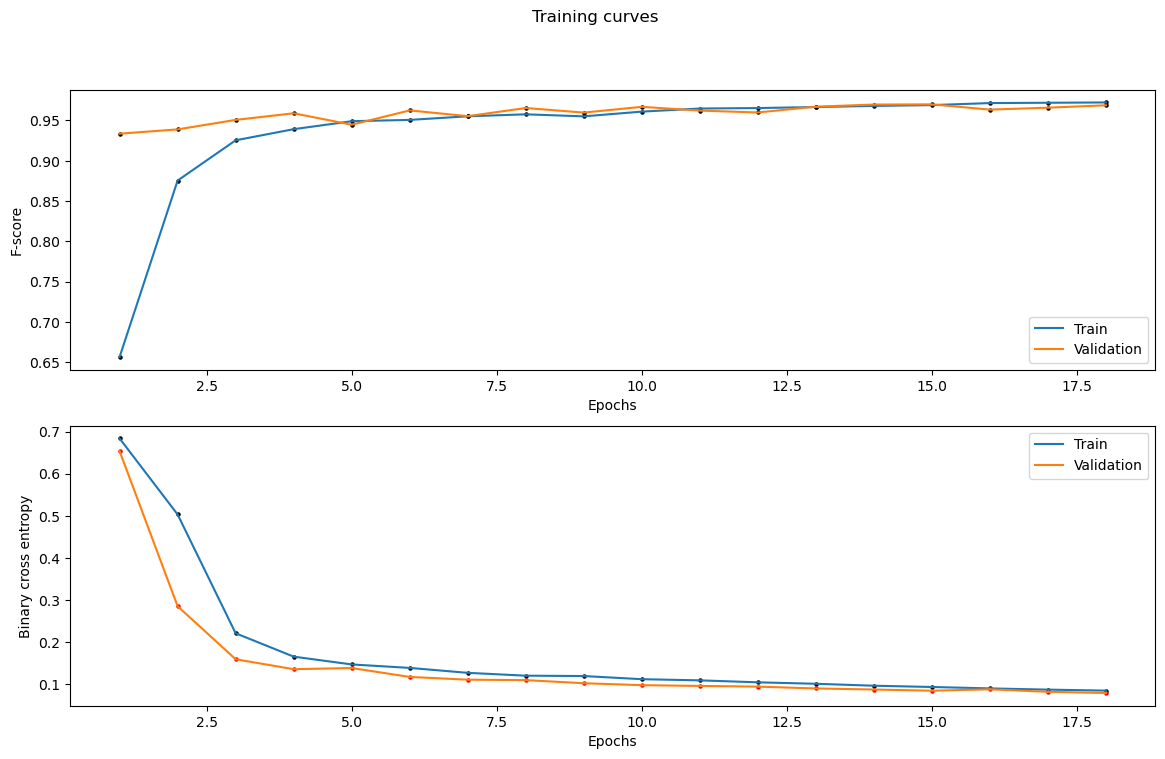

In [225]:
print("Temps d'entrainement : ", time_train, "s")

x = np.arange(1,len(history.history['loss'])+1,1)

plt.figure(figsize=(14,8))
plt.suptitle("Training curves")
plt.subplot(211)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(x,history.history['f_score'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_f_score'], s=5, c='k')
plt.plot(x,history.history['val_f_score'], label='Validation'), plt.legend()
plt.ylabel("F-score")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['loss'], s=5, c='k')
plt.plot(x,history.history['loss'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_loss'], s=5, c='r')
plt.plot(x,history.history['val_loss'], label='Validation'), plt.legend()
plt.ylabel("Binary cross entropy")
plt.xlabel("Epochs")

In [226]:
#Data test second set
#shuffle
c = list(zip(GLS_test2, Maxs_test2,Label_test2))
random.shuffle(c)
X_GLS_test2, X_Maxs_test2,Y_test2 = zip(*c)

#Periodogramme
X1_test_tensor2 = tf.convert_to_tensor(X_GLS_test2, dtype= 'float32')
X1_test_shape2 =  [len(X_GLS_test2),len(X_GLS_test2[0]), 1]
X_GLS_test2 = tf.reshape(X1_test_tensor2, X1_test_shape2 )

#Max values
X2_test_tensor2 = tf.convert_to_tensor(X_Maxs_test2, dtype= 'float32')
X_maxs_test2 = tf.reshape(X2_test_tensor2, (len(X_Maxs_test2), len(X_Maxs_test2[0]),1))

#Label
Y_test_tensor2 = tf.convert_to_tensor(Y_test2)
Y_test2 = tf.reshape(Y_test_tensor2, (len(Y_test2),1 ))

print("X1_test shape : ", X_GLS_test2.shape)
print("X2_test shape : ", X_maxs_test2.shape)
print("label_test shape : ", Y_test2.shape)

X1_test shape :  (1000, 990, 1)
X2_test shape :  (1000, 2, 1)
label_test shape :  (1000, 1)


In [238]:
y_pred_cnn2 = model2.predict( x =[X_GLS_test2, X_maxs_test2])

32/32 [==============================] - 1s 40ms/step


Text(0, 0.5, 'Pdet')

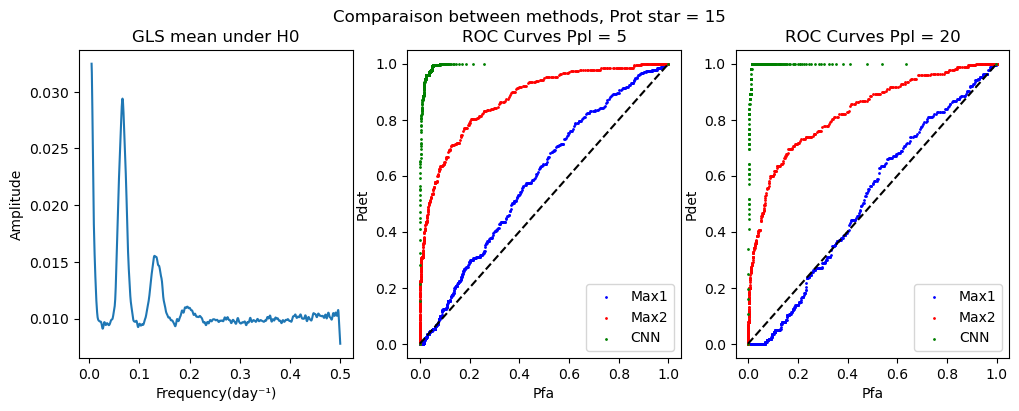

In [250]:
#Comparaison between cnn and max test normalized by h0 distribution on fixed GP parameters data 
N = 1000

threshold_max11 = np.linspace(np.min(Maxs11),np.max(Maxs11),N)
threshold_max12 = np.linspace(np.min(Maxs12),np.max(Maxs12),N)

threshold_max21 = np.linspace(np.min(Maxs21),np.max(Maxs21),N)
threshold_max22 = np.linspace(np.min(Maxs22),np.max(Maxs21),N)

threshold_cnn1 = np.linspace(np.min(y_pred_cnn1),np.max(y_pred_cnn1),N)
threshold_cnn2 = np.linspace(np.min(y_pred_cnn2),np.max(y_pred_cnn2),N)


Pdet11, Pfa11 = np.zeros(N), np.zeros(N)
Pdet12, Pfa12 = np.zeros(N), np.zeros(N)

Pdet21, Pfa21 = np.zeros(N), np.zeros(N)
Pdet22, Pfa22 = np.zeros(N), np.zeros(N)

Pdetcnn1, Pfacnn1 = np.zeros(N), np.zeros(N)
Pdetcnn2, Pfacnn2 = np.zeros(N), np.zeros(N)


for i in range(N):
    y_seuil = np.where(Maxs11 > threshold_max11[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test1)
    Pdet11[i], Pfa11[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
        
    y_seuil = np.where(Maxs12 > threshold_max12[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test2)
    Pdet12[i], Pfa12[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    
    y_seuil = np.where(Maxs21 > threshold_max21[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test1)
    Pdet21[i], Pfa21[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
        
    y_seuil = np.where(Maxs22 > threshold_max22[i],1,0)
    p,r,f,m = evaluate(y_seuil,Label_test2)
    Pdet22[i], Pfa22[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    
    y_seuil = np.where(y_pred_cnn1 > threshold_cnn1[i],1,0)
    p,r,f,m = evaluate(y_seuil,Y_test1)
    Pdetcnn1[i], Pfacnn1[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    
    y_seuil = np.where(y_pred_cnn2 > threshold_cnn2[i],1,0)
    p,r,f,m = evaluate(y_seuil,Y_test2)
    Pdetcnn2[i], Pfacnn2[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    
    
plt.figure(figsize=(12,4))
plt.suptitle("Comparaison between methods, Prot star = 15\n")

plt.subplot(131)
plt.title("GLS mean under H0")
plt.plot(freq,GLS_mean_H0)
plt.xlabel("Frequency(day⁻¹)")
plt.ylabel("Amplitude")

plt.subplot(132)
plt.title("ROC Curves Ppl = 5")
plt.scatter(Pfa11, Pdet11, label='Max1', s=1, c='b'),plt.legend()
plt.scatter(Pfa21, Pdet21, label='Max2', s=1, c='r'),plt.legend()
plt.scatter(Pfacnn1, Pdetcnn1, label='CNN', s=1, c='g'),plt.legend()
plt.plot(np.linspace(0,1,N),np.linspace(0,1,N), '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")

plt.subplot(133)
plt.title("ROC Curves Ppl = 20")
plt.scatter(Pfa12, Pdet12, label='Max1', s=1, c='b'),plt.legend()
plt.scatter(Pfa22, Pdet22, label='Max2', s=1, c='r'),plt.legend()
plt.scatter(Pfacnn2, Pdetcnn2, label='CNN', s=1, c='g'),plt.legend()
plt.plot( np.linspace(0,1,N), np.linspace(0,1,N), '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")

## Same but with planet injected randomly

In [274]:
#Data train for CNN
N_train = 10000

#Params_second planet signal
X_GLS = []
X_maxs = []
Label = []

count_neg = 0
count_pos = 0

while (count_pos < round(N_train/2)):
    #H1 data
    Ppl= 1/random.uniform(0.01,0.2) 
    A = loguniform.rvs(0.1, 5)
    T0 = random.uniform(0,Ppl) 
    params_pl = [Ppl,A,T0]
    GLS, Maxs, label = generate_data(t,dt,Ttot,freq,params_gp,params_gr, params_pl,1)
    if ( label == 1):
        X_GLS.append(GLS)
        X_maxs.append(Maxs)
        Label.append(label)
        count_pos +=1
    if ( label == 0 and count_neg < round(N_train/4)):
        X_GLS.append(GLS)
        X_maxs.append(Maxs)
        Label.append(label)
        count_neg +=1
        
print("count positive = ", count_pos)
print("count negative = ", count_neg)

#H0 data
while(count_neg < round(N_train/2)):
    GLS, Maxs, label = generate_data(t,dt,Ttot,freq,params_gp,params_gr, [0,0,0],0)
    X_GLS.append(GLS)
    X_maxs.append(Maxs)
    Label.append(label)
    count_neg +=1

print("count positive = ", count_pos)
print("count negative = ", count_neg)

count positive =  5000
count negative =  2500
count positive =  5000
count negative =  5000


In [275]:
#Data pre-processing 

#shuffle
c = list(zip(X_GLS, X_maxs,Label))
random.shuffle(c)
GLS, maxs, Y = zip(*c)

#Periodogramme
X_shape =  [N_train,len(X_GLS[0]), 1]
X1_tensor = tf.convert_to_tensor(GLS, dtype = 'float32')
X1 = tf.reshape(X1_tensor, X_shape )

#Max values
X2_tensor = tf.convert_to_tensor(maxs, dtype = 'float32')
X2 = tf.reshape(X2_tensor, (N_train, 2,1))

#Label
Y_tensor = tf.convert_to_tensor(Y,dtype='float32')
Y = tf.reshape(Y_tensor, (N_train,1 ))

#Split train/validation
pourcentage = 0.8
split = round(pourcentage * N_train)
X_train_GLS, X_val_GLS = X1[0:split, :, :], X1[split:, :, :]
X_train_maxs,X_val_maxs = X2[0:split, :, :], X2[split:, :, :]
Y_train, Y_val = Y[0:split], Y[split:,:]

print("Periodogramme train size : ", X_train_GLS.shape)
print("Periodogramme validation size : ", X_val_GLS.shape,"\n")
print("Max_values train size : ", X_train_maxs.shape)
print("Max_values validation size : ", X_val_maxs.shape,"\n")
print("Label train size : ", Y_train.shape)
print("Label validation size : ", Y_val.shape)

Periodogramme train size :  (8000, 990, 1)
Periodogramme validation size :  (2000, 990, 1) 

Max_values train size :  (8000, 2, 1)
Max_values validation size :  (2000, 2, 1) 

Label train size :  (8000, 1)
Label validation size :  (2000, 1)


In [307]:
#Model with functional API Keras

#periodogramme as input to a CNN
inputs1 = tf.keras.Input(shape=(990,1))
x1 = layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, padding = 'same',
                   activation='relu', use_bias = True,input_shape= (990,1))(inputs1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,6,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,8,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
outputs1 = layers.Flatten()(x1)

#max_values as input to a dense layers 
inputs2 = tf.keras.Input(shape=(2,1))
x2 = layers.Dense(2, activation = 'relu')(inputs2)
outputs2 =  layers.Flatten()(x2)

#output of the two network concatenate for input as a dense final network
x = layers.concatenate([outputs1, outputs2])

x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

In [308]:
model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="ExoplANNET")

In [309]:
#Cnn
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f_score', patience = 3, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

model.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4),
              metrics =[tf.keras.metrics.BinaryAccuracy(),precision_m, recall_m, f_score])

y_before_train = model.evaluate( x = [X_train_GLS, X_train_maxs], y = Y_train, batch_size = 128)

63/63 [==============================] - 4s 50ms/step - loss: 0.6931 - binary_accuracy: 0.5562 - precision_m: 0.7083 - recall_m: 0.1871 - f_score: 0.2928


In [310]:
#Train cnn
start = time.time()
history = model.fit(x = [X_train_GLS, X_train_maxs], y = Y_train, batch_size = 128, epochs = 50, verbose = 1,
                    callbacks=[early_stopping], validation_data = ([X_val_GLS,X_val_maxs], Y_val))                                                      
time_train = time.time() - start

Epoch 1/50
63/63 [==============================] - 11s 143ms/step - loss: 0.6771 - binary_accuracy: 0.7078 - precision_m: 0.8074 - recall_m: 0.5922 - f_score: 0.6496 - val_loss: 0.6143 - val_binary_accuracy: 0.8065 - val_precision_m: 0.8505 - val_recall_m: 0.7565 - val_f_score: 0.7995
Epoch 2/50
63/63 [==============================] - 7s 118ms/step - loss: 0.4981 - binary_accuracy: 0.7779 - precision_m: 0.8236 - recall_m: 0.7172 - f_score: 0.7598 - val_loss: 0.3962 - val_binary_accuracy: 0.8235 - val_precision_m: 0.8814 - val_recall_m: 0.7596 - val_f_score: 0.8148
Epoch 3/50
63/63 [==============================] - 8s 132ms/step - loss: 0.4059 - binary_accuracy: 0.8116 - precision_m: 0.8470 - recall_m: 0.7663 - f_score: 0.8015 - val_loss: 0.3689 - val_binary_accuracy: 0.8330 - val_precision_m: 0.9486 - val_recall_m: 0.7137 - val_f_score: 0.8138
Epoch 4/50
63/63 [==============================] - 9s 143ms/step - loss: 0.3548 - binary_accuracy: 0.8436 - precision_m: 0.8947 - recall_m: 

Temps d'entrainement :  96.95022654533386 s


Text(0.5, 0, 'Epochs')

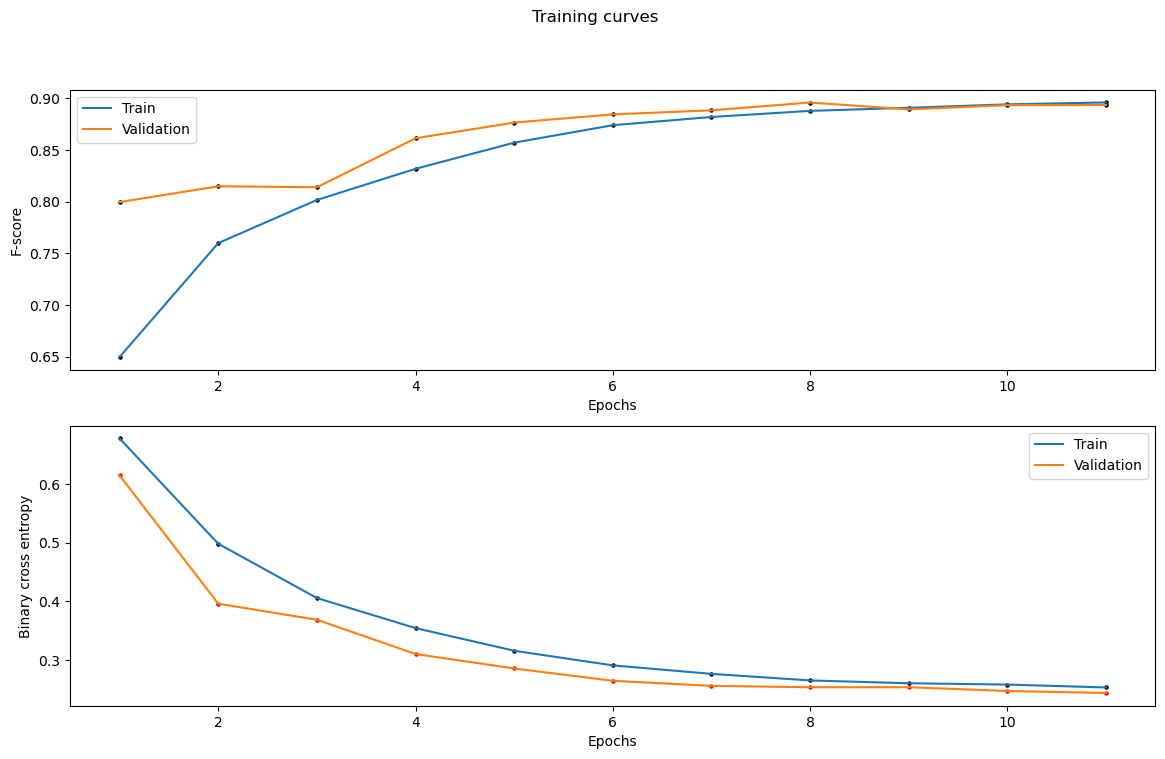

In [311]:
print("Temps d'entrainement : ", time_train, "s")

x = np.arange(1,len(history.history['loss'])+1,1)

plt.figure(figsize=(14,8))
plt.suptitle("Training curves")
plt.subplot(211)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(x,history.history['f_score'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_f_score'], s=5, c='k')
plt.plot(x,history.history['val_f_score'], label='Validation'), plt.legend()
plt.ylabel("F-score")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['loss'], s=5, c='k')
plt.plot(x,history.history['loss'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_loss'], s=5, c='r')
plt.plot(x,history.history['val_loss'], label='Validation'), plt.legend()
plt.ylabel("Binary cross entropy")
plt.xlabel("Epochs")

In [281]:
#Data test
N_test = 3000

GLS_test, Maxs_test, Label_test = np.zeros((N_test, freq.shape[0])), np.zeros((N_test,2)), np.zeros(N_test)

for i in range(round(N_test/2)):
    Ppl= 1/random.uniform(0.01,0.2) 
    A = loguniform.rvs(0.1, 5)
    T0 = random.uniform(0,Ppl) 
    params_pl = [Ppl,A,T0]
    GLS_test[i,:], Maxs_test[i,:], Label_test[i] = generate_data(t,dt,Ttot,freq,params_gp,params_gr, params_pl,1)
 
 
for i in range(round(N_test/2),N_test):
    GLS_test[i,:], Maxs_test[i,:], Label_test[i] = generate_data(t,dt,Ttot,freq,params_gp,params_gr, [0,0,0],0)


In [282]:
#Data test
#shuffle
c = list(zip(GLS_test, Maxs_test,Label_test))
random.shuffle(c)
X_GLS_test, X_Maxs_test,Y_test = zip(*c)

#Periodogramme
X1_test_tensor = tf.convert_to_tensor(X_GLS_test, dtype= 'float32')
X1_test_shape =  [len(X_GLS_test),len(X_GLS_test[0]), 1]
X_GLS_test = tf.reshape(X1_test_tensor, X1_test_shape )

#Max values
X2_test_tensor = tf.convert_to_tensor(X_Maxs_test, dtype= 'float32')
X_maxs_test = tf.reshape(X2_test_tensor, (len(X_Maxs_test), len(X_Maxs_test[0]),1))

#Label
Y_test_tensor = tf.convert_to_tensor(Y_test)
Y_test = tf.reshape(Y_test_tensor, (len(Y_test),1 ))

print("X1_test shape : ", X_GLS_test.shape)
print("X2_test shape : ", X_maxs_test.shape)
print("label_test shape : ", Y_test.shape)

X1_test shape :  (3000, 990, 1)
X2_test shape :  (3000, 2, 1)
label_test shape :  (3000, 1)


In [312]:
#First test, take the maximum and compared to a threshold
Maxs1 = X_maxs_test[:,1]
#Second test, divide GLS_test by mean_GLS under H0, and take the max
Maxs2 = np.max(np.reshape(X_GLS_test.numpy(), (N_test,freq.shape[0])) / GLS_mean_H0, axis = 1)
#Third test, with CNN
y_pred_cnn =  model.predict( x =[X_GLS_test, X_maxs_test])

94/94 [==============================] - 5s 54ms/step


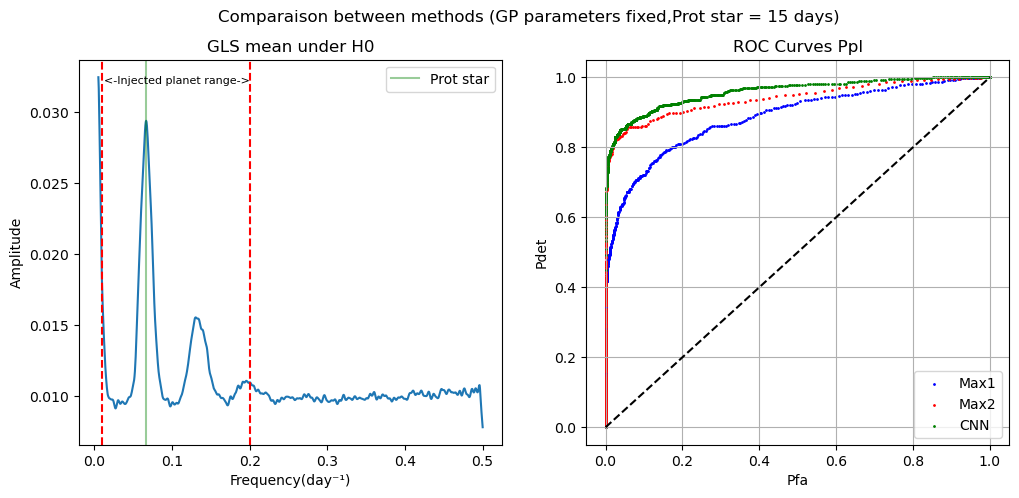

In [478]:
#Comparaison between cnn and max test normalized by h0 distribution on fixed GP parameters data 
N = 1000

threshold_max1 = np.linspace(np.min(Maxs1),np.max(Maxs1),N)
threshold_max2 = np.linspace(np.min(Maxs2),np.max(Maxs2),N)
threshold_cnn = np.linspace(np.min(y_pred_cnn),np.max(y_pred_cnn),N)

Pdet1, Pfa1 = np.zeros(N), np.zeros(N)
Pdet2, Pfa2 = np.zeros(N), np.zeros(N)
Pdetcnn, Pfacnn = np.zeros(N), np.zeros(N)

for i in range(N):
    y_seuil = np.where(Maxs1 > threshold_max1[i],1,0)
    p,r,f,m = evaluate(y_seuil,Y_test)
    Pdet1[i], Pfa1[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
        
    y_seuil = np.where(Maxs2 > threshold_max2[i],1,0)
    p,r,f,m = evaluate(y_seuil,Y_test)
    Pdet2[i], Pfa2[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])

    y_seuil = np.where(y_pred_cnn > threshold_cnn[i],1,0)
    p,r,f,m = evaluate(y_seuil,Y_test)
    Pdetcnn[i], Pfacnn[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    
    
plt.figure(figsize=(12,5))
plt.suptitle("Comparaison between methods (GP parameters fixed,Prot star = 15 days)\n")

plt.subplot(121)
plt.title("GLS mean under H0")
plt.plot(freq,GLS_mean_H0)
plt.axvline(x = 0.01, color = 'r', linestyle='dashed')
plt.axvline(x = 0.2 , color = 'r', linestyle='dashed')
plt.axvline(x = 1/Prot ,color = 'g', alpha = 0.4, label = 'Prot star'), plt.legend()
plt.text(0.012,0.032,'<-Injected planet range->',fontsize=8)
plt.xlabel("Frequency(day⁻¹)")
plt.ylabel("Amplitude")

plt.subplot(122)
plt.title("ROC Curves Ppl")
plt.scatter(Pfa1, Pdet1, label='Max1', s=1, c='b'),plt.legend()
plt.scatter(Pfa2, Pdet2, label='Max2', s=1, c='r'),plt.legend()
plt.scatter(Pfacnn, Pdetcnn, label='CNN', s=1, c='g'),plt.legend()
plt.plot(np.linspace(0,1,N),np.linspace(0,1,N), '--', c='black')
plt.grid()
plt.xlabel("Pfa")
plt.ylabel("Pdet")
plt.savefig("./../Result/ROC_comparaison.png")

In [397]:
# Threshold for Pfa = 0.2
s_cnn = threshold_cnn[np.argmin( np.abs(Pfacnn-0.2) )]
y_cnn = np.where(y_pred_cnn > s_cnn,1,0)
p,r,f,m_cnn = evaluate(y_cnn,Y_test)

s_max = threshold_max1[np.argmin( np.abs(Pfa1-0.2) )]
y_max = np.where(Maxs1 > s_max,1,0)
p,r,f,m_max = evaluate(y_max,Y_test)

In [400]:
Result_cnn, Result_max = np.zeros(N_test),np.zeros(N_test)

#CNN
for i in range(N_test):
    if (y_cnn[i][0] == Y_test[i]):
        if( y_cnn[i][0] == 0) : Result_cnn[i] = 0 # True negatif
        if (y_cnn[i][0] == 1) : Result_cnn[i] = 1 # True positif
    else:
        if( y_cnn[i][0] == 0) : Result_cnn[i] = -1 # False negatif
        if (y_cnn[i][0] == 1) : Result_cnn[i] = -2 # False positif 
            
#Max test
for i in range(N_test):
    if (y_max[i][0] == Y_test[i]):
        if( y_max[i][0] == 0) : Result_max[i] = 0 # True negatif
        if (y_max[i][0] == 1) : Result_max[i] = 1 # True positif
    else:
        if( y_max[i][0] == 0) : Result_max[i] = -1 # False negatif
        if (y_max[i][0] == 1) : Result_max[i] = -2 # False positif  
    

In [403]:
 X_maxs_test[0][1]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.05629545], dtype=float32)>

In [422]:
colors[0]

'green'

'\n\nplt.scatter(X_maxs_test[:,0], X_maxs_test[:,1], c = Result_max)\nplt.xlabel("frequency(day⁻¹)")\nplt.ylabel("Amplitude (s.u)")\n\nplt.subplot(122)\nplt.title("CNN")\nplt.scatter(X_maxs_test[:,0], X_maxs_test[:,1], c = Result_cnn)\nplt.xlabel("frequency(day⁻¹)")\nplt.ylabel("Amplitude")\n'

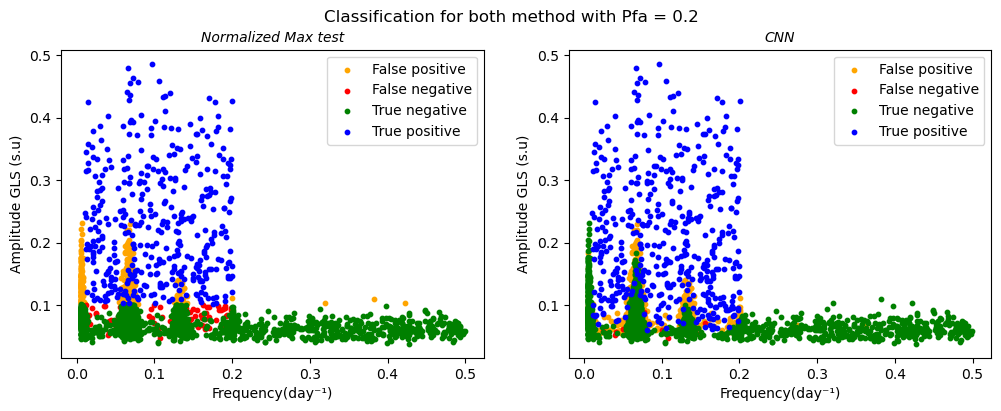

In [455]:
colors = {0:'green', 1:'blue', -1:'Red', -2:'Orange'}
labels = {0:'True negative', 1:'True positive', -1:'False negative', -2:'False positive'}

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4))
fig.suptitle('Result classification for both method with Pfa = 0.2')

ax1.set_title('Normalized Max test', loc='center', fontstyle='oblique', fontsize='medium')
ax1.set_xlabel("Frequency(day⁻¹)")
ax1.set_ylabel("Amplitude GLS (s.u)")
for g in np.unique(Result_max):
    ix = np.where(Result_max == g)
    ax1.scatter(X_maxs_test.numpy()[ix,0], X_maxs_test.numpy()[ix,1], c = colors[g], label = labels[g], s = 10)
ax1.legend()

ax2.set_title('CNN', loc='center', fontstyle='oblique', fontsize='medium')
ax2.set_xlabel("Frequency(day⁻¹)")
ax2.set_ylabel("Amplitude GLS (s.u)")
for g in np.unique(Result_cnn):
    ix = np.where(Result_cnn == g)
    ax2.scatter(X_maxs_test.numpy()[ix,0], X_maxs_test.numpy()[ix,1], c = colors[g], label = labels[g], s = 10)
ax2.legend()

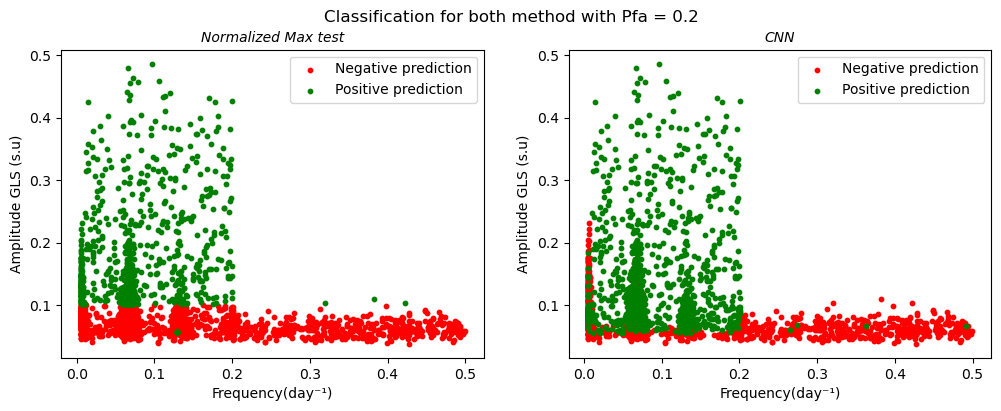

In [457]:
colors_c = {0:'red', 1:'green'}
labels_c = {0:'Negative prediction', 1:'Positive prediction'}

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4))
fig.suptitle('Classification for both method with Pfa = 0.2')

ax1.set_title('Normalized Max test', loc='center', fontstyle='oblique', fontsize='medium')
ax1.set_xlabel("Frequency(day⁻¹)")
ax1.set_ylabel("Amplitude GLS (s.u)")
for g in np.unique(y_max):
    ix = np.where(y_max == g)
    ax1.scatter(X_maxs_test.numpy()[ix,0], X_maxs_test.numpy()[ix,1], c = colors[g], label = labels[g], s = 10)
ax1.legend()

ax2.set_title('CNN', loc='center', fontstyle='oblique', fontsize='medium')
ax2.set_xlabel("Frequency(day⁻¹)")
ax2.set_ylabel("Amplitude GLS (s.u)")
for g in np.unique(y_cnn):
    ix = np.where(y_cnn == g)
    ax2.scatter(X_maxs_test.numpy()[ix,0], X_maxs_test.numpy()[ix,1], c = colors[g], label = labels[g], s = 10)
ax2.legend()


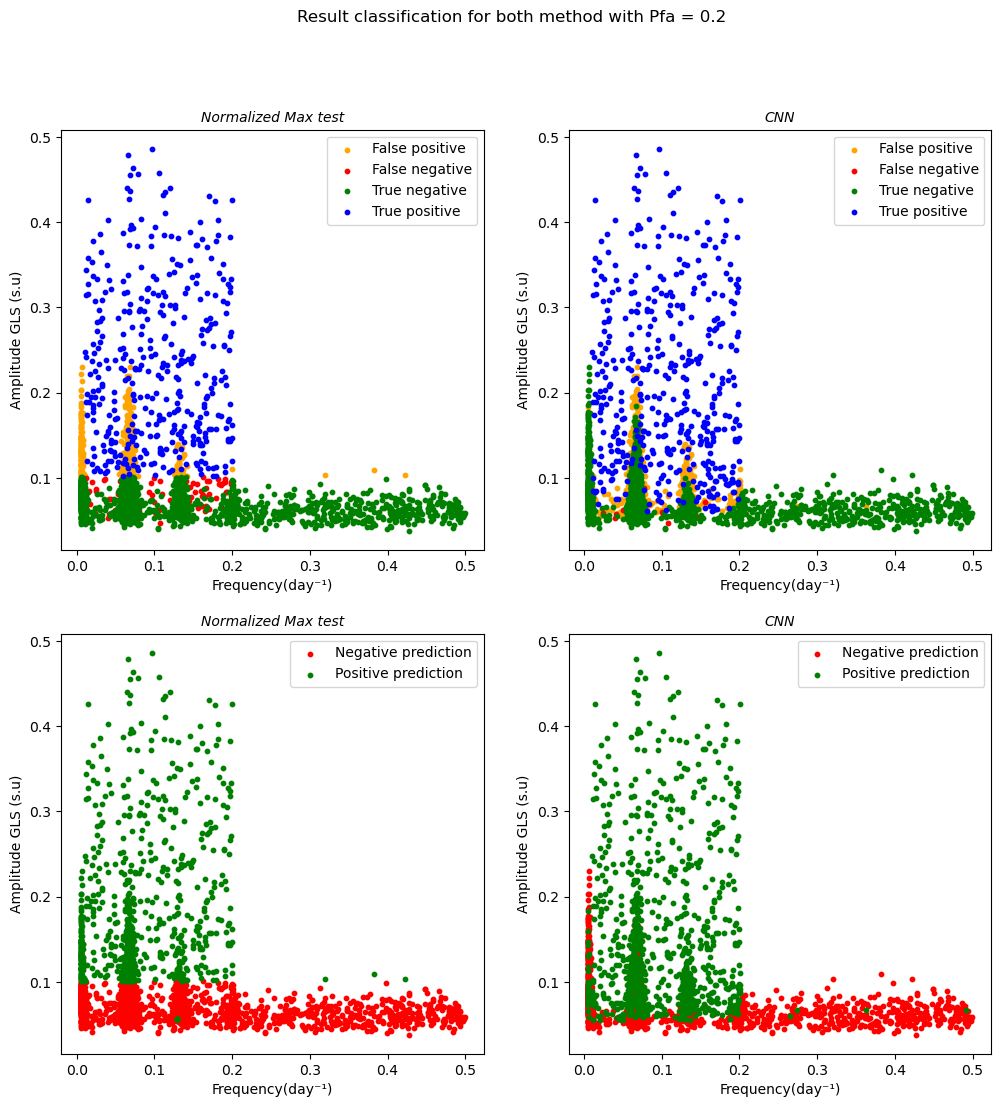

In [471]:
colors = {0:'green', 1:'blue', -1:'Red', -2:'Orange'}
labels = {0:'True negative', 1:'True positive', -1:'False negative', -2:'False positive'}

colors_c = {0:'red', 1:'green'}
labels_c = {0:'Negative prediction', 1:'Positive prediction'}

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12, 12))
fig.suptitle('Result classification for both method with Pfa = 0.2')

ax1.set_title('Normalized Max test', loc='center', fontstyle='oblique', fontsize='medium')
ax1.set_xlabel("Frequency(day⁻¹)")
ax1.set_ylabel("Amplitude GLS (s.u)")
for g in np.unique(Result_max):
    ix = np.where(Result_max == g)
    ax1.scatter(X_maxs_test.numpy()[ix,0], X_maxs_test.numpy()[ix,1], c = colors[g], label = labels[g], s = 10)
ax1.legend()

ax2.set_title('CNN', loc='center', fontstyle='oblique', fontsize='medium')
ax2.set_xlabel("Frequency(day⁻¹)")
ax2.set_ylabel("Amplitude GLS (s.u)")
for g in np.unique(Result_cnn):
    ix = np.where(Result_cnn == g)
    ax2.scatter(X_maxs_test.numpy()[ix,0], X_maxs_test.numpy()[ix,1], c = colors[g], label = labels[g], s = 10)
ax2.legend()

ax3.set_title('Normalized Max test', loc='center', fontstyle='oblique', fontsize='medium')
ax3.set_xlabel("Frequency(day⁻¹)")
ax3.set_ylabel("Amplitude GLS (s.u)")
for g in np.unique(y_max):
    ix = np.where(y_max == g)
    ax3.scatter(X_maxs_test.numpy()[ix,0], X_maxs_test.numpy()[ix,1], c = colors_c[g], label = labels_c[g], s = 10)
ax3.legend()

ax4.set_title('CNN', loc='center', fontstyle='oblique', fontsize='medium')
ax4.set_xlabel("Frequency(day⁻¹)")
ax4.set_ylabel("Amplitude GLS (s.u)")
for g in np.unique(y_cnn):
    ix = np.where(y_cnn == g)
    ax4.scatter(X_maxs_test.numpy()[ix,0], X_maxs_test.numpy()[ix,1], c = colors_c[g], label = labels_c[g], s = 10)
ax4.legend()

plt.savefig("./../Result/Classification_comparaison.png")